In [1]:
pID = 6
pID = 'sub-' + "%03d" % (pID)

In [2]:
import os

import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as ABC

from sklearn.model_selection import cross_val_score, KFold

import pickle, json, os
import scipy.io
from bci_funcs import windowed_mean, base_correct, select_mean, slope

path = '/Volumes/Lukas_Gehrke/fastReach/data/eeglab2python'

# Preconscious Augmentation

This script trains the classifier for a brain-computer interface that controls electrical muscle stimulation in the preconscious augmentation experiment.
The functions used to build the feature vectors are the same that are used for the online application and are found in 'bci_funcs'

A two class linear discriminant model is fitted to idle and pre-movement EEG training data. The model and a channel selection is saved.

In [3]:
# load data
pre_move = scipy.io.loadmat(path+os.sep+pID+os.sep+'pre_move_Baseline.mat')
idle = scipy.io.loadmat(path+os.sep+pID+os.sep+'idle_Baseline.mat')
all_idle = idle['idle']
all_pre_move = pre_move['pre_move']

## Select Best Channels by Slope

In [4]:
# slope_idle = np.zeros((idle.shape[2], idle.shape[0]))
# slope_pre_move = np.zeros((pre_move.shape[2], pre_move.shape[0]))

# for trial_ix in range(0, pre_move.shape[2]):
#     slope_pre_move[trial_ix, :] = slope(pre_move[:,:,trial_ix], 'linear').flatten()

# for trial_ix in range(0, idle.shape[2]):
#     slope_idle[trial_ix, :] = slope(idle[:,:,trial_ix], 'linear').flatten()

# crit1 = pd.DataFrame(slope_pre_move.mean(axis=0)).sort_values(by=0, ascending=False)
# crit1['chans'] = crit1.index
# crit1['crit1_ranks'] = crit1.reset_index().index
# crit1.sort_values(by='chans', inplace=True)

# crit2 = pd.DataFrame(slope_idle.mean(axis=0)).sort_values(by=0, ascending=True)
# crit2['chans'] = crit2.index
# crit2['crit2_ranks'] = crit2.reset_index().index
# crit2.sort_values(by='chans', inplace=True)

# crits = pd.concat([crit1.chans, crit1.crit1_ranks, crit2.crit2_ranks], axis=1)
# crits['mean_ranks'] = crits[['crit1_ranks', 'crit2_ranks']].mean(axis=1)
# crits.sort_values(by='mean_ranks', inplace=True)
# chans = crits.chans.values

# chans = chans[:nr_chans]
# chan_names.Var1[chans]

## Compute Features

In [5]:
# data = slope

# data_to_plot = pd.DataFrame(data)
# data_to_plot['class'] = classes
# data_to_plot = data_to_plot.melt(id_vars = 'class', value_name = 'amplitude')

# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set_theme(style="ticks")
# sns.displot(x="amplitude", hue="class", data=data_to_plot, kde=True, fill=True, stat="density")


In [6]:
# from lazypredict.Supervised import LazyClassifier
# from sklearn.model_selection import train_test_split

# for i in range(1, 10):
#     X_train, X_test, y_train, y_test = train_test_split(np.asarray(data), classes, test_size=.1)#,random_state =123)

#     clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
#     models,predictions = clf.fit(X_train, X_test, y_train, y_test)
#     print(models)

# Compute Features & Model fitting

In [7]:
nr_chans_arr = np.arange(2,21,2) # select one and then save the model

data_srate = 250
windows = 10
baseline = data_srate/windows
target_class = 1.0
classifier_update_rate = 5 # samples

chan_names = pd.read_csv(path+os.sep+pID+os.sep+'sel_chans_names.csv')
all_chans = pd.read_csv(path+os.sep+pID+os.sep+'sel_chans.csv', header=None)

feat = 'slope' # slope or slope_2d

for nr_chans in nr_chans_arr:
    print(str(nr_chans) + ' channels')

    chans = np.squeeze(np.array(all_chans[0:nr_chans]) - 1).tolist()
    # print(chan_names.Var1[chans])

    idle = all_idle[chans, :, :]
    pre_move = all_pre_move[chans, :, :]

    if feat == 'slope':
        idle_feat = np.zeros((idle.shape[2], idle.shape[0]))
        pre_move_feat = np.zeros((pre_move.shape[2], pre_move.shape[0]))

    elif feat == 'slope2d':
        idle_feat = np.zeros((idle.shape[2], idle.shape[0]*2))
        pre_move_feat = np.zeros((pre_move.shape[2], pre_move.shape[0]*2))

    elif feat == 'windowed_means':
        idle_feat = np.zeros((idle.shape[2], idle.shape[0] * (windows)))
        pre_move_feat = np.zeros((pre_move.shape[2], pre_move.shape[0] * (windows)))

    for trial_ix in range(0, pre_move.shape[2]):
        if feat == 'slope':
            pre_move_feat[trial_ix, :] = slope(pre_move[:,:,trial_ix], 'linear').flatten()
        
        elif feat == 'slope2d':
            pre_move_feat[trial_ix, :idle.shape[0]] = slope(pre_move[:,:150,trial_ix], 'linear').flatten()
            pre_move_feat[trial_ix, idle.shape[0]:] = slope(pre_move[:,150:,trial_ix], 'linear').flatten()

        elif feat == 'windowed_means':
            tmp = base_correct(pre_move[:,:,trial_ix], baseline-1)
            pre_move_feat[trial_ix, :] = windowed_mean(tmp, windows).flatten()

    for trial_ix in range(0, idle.shape[2]):
        if feat == 'slope':
            idle_feat[trial_ix, :] = slope(idle[:,:,trial_ix], 'linear').flatten()    
        
        elif feat == 'slope2d':
            idle_feat[trial_ix, :idle.shape[0]] = slope(idle[:,:150,trial_ix], 'linear').flatten()
            idle_feat[trial_ix, idle.shape[0]:] = slope(idle[:,150:,trial_ix], 'linear').flatten()

        elif feat == 'windowed_means':
            tmp = base_correct(idle[:,:,trial_ix], baseline-1)
            idle_feat[trial_ix, :] = windowed_mean(tmp, windows).flatten()

    data = np.concatenate((pre_move_feat, idle_feat), axis = 0)
    pre_move_class = np.ones((pre_move_feat.shape[0], 1))
    idle_class = np.zeros((idle_feat.shape[0], 1))
    classes = np.concatenate((pre_move_class, idle_class)).ravel()

    clf = LDA(solver='eigen', shrinkage='auto')
    clf.fit(data, classes)
    kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
    cv_results = cross_val_score(clf, data, classes, cv=kfolds)
    print("LDA accuracy: " + str(cv_results.mean()) + " +/- " + str(cv_results.std()))

    # clf = ABC()
    # clf.fit(data, classes)
    # kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
    # cv_results = cross_val_score(clf, data, classes, cv=kfolds)
    # print("ABC accuracy: " + str(cv_results.mean()) + " +/- " + str(cv_results.std()))

    # clf = QDA()
    # clf.fit(data, classes)
    # kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
    # cv_results = cross_val_score(clf, data, classes, cv=kfolds)
    # print("QDA accuracy: " + str(cv_results.mean()) + " +/- " + str(cv_results.std()))

    # clf = RFC()
    # clf.fit(data, classes)
    # kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
    # cv_results = cross_val_score(clf, data, classes, cv=kfolds)
    # print("RFC accuracy: " + str(cv_results.mean()) + " +/- " + str(cv_results.std()))

2 channels
LDA accuracy: 0.6 +/- 0.07536891516255931
4 channels
LDA accuracy: 0.5999999999999999 +/- 0.0670599837467796
6 channels
LDA accuracy: 0.6846153846153846 +/- 0.05102499677469847
8 channels
LDA accuracy: 0.7 +/- 0.02878197989826107
10 channels
LDA accuracy: 0.6846153846153846 +/- 0.05102499677469846
12 channels
LDA accuracy: 0.7076923076923076 +/- 0.057563959796522166
14 channels
LDA accuracy: 0.7 +/- 0.07457969011409737
16 channels
LDA accuracy: 0.7307692307692306 +/- 0.0344010458076891
18 channels
LDA accuracy: 0.7538461538461539 +/- 0.0307692307692308
20 channels
LDA accuracy: 0.7538461538461538 +/- 0.0307692307692308


# Real-time Detection

In [29]:
nr_chans = 10

chans = np.squeeze(np.array(all_chans[0:nr_chans]) - 1).tolist()
print(chan_names.Var1[chans])
idle = all_idle[chans, :, :]
pre_move = all_pre_move[chans, :, :]

feat = 'slope'
if feat == 'slope':
    idle_feat = np.zeros((idle.shape[2], idle.shape[0]))
    pre_move_feat = np.zeros((pre_move.shape[2], pre_move.shape[0]))

elif feat == 'slope2d':
    idle_feat = np.zeros((idle.shape[2], idle.shape[0]*2))
    pre_move_feat = np.zeros((pre_move.shape[2], pre_move.shape[0]*2))

elif feat == 'windowed_means':
    idle_feat = np.zeros((idle.shape[2], idle.shape[0] * (windows)))
    pre_move_feat = np.zeros((pre_move.shape[2], pre_move.shape[0] * (windows)))

for trial_ix in range(0, pre_move.shape[2]):
    if feat == 'slope':
        pre_move_feat[trial_ix, :] = slope(pre_move[:,:,trial_ix], 'linear').flatten()
    
    elif feat == 'slope2d':
        pre_move_feat[trial_ix, :idle.shape[0]] = slope(pre_move[:,:150,trial_ix], 'linear').flatten()
        pre_move_feat[trial_ix, idle.shape[0]:] = slope(pre_move[:,150:,trial_ix], 'linear').flatten()

    elif feat == 'windowed_means':
        tmp = base_correct(pre_move[:,:,trial_ix], baseline-1)
        pre_move_feat[trial_ix, :] = windowed_mean(tmp, windows).flatten()

for trial_ix in range(0, idle.shape[2]):
    if feat == 'slope':
        idle_feat[trial_ix, :] = slope(idle[:,:,trial_ix], 'linear').flatten()    
    
    elif feat == 'slope2d':
        idle_feat[trial_ix, :idle.shape[0]] = slope(idle[:,:150,trial_ix], 'linear').flatten()
        idle_feat[trial_ix, idle.shape[0]:] = slope(idle[:,150:,trial_ix], 'linear').flatten()

    elif feat == 'windowed_means':
        tmp = base_correct(idle[:,:,trial_ix], baseline-1)
        idle_feat[trial_ix, :] = windowed_mean(tmp, windows).flatten()

data = np.concatenate((pre_move_feat, idle_feat), axis = 0)
pre_move_class = np.ones((pre_move_feat.shape[0], 1))
idle_class = np.zeros((idle_feat.shape[0], 1))
classes = np.concatenate((pre_move_class, idle_class)).ravel()

### COPY IN WHERE BEST CLASSIFICATION PERFORMANCE WAS ACHIEVED ###

clf = LDA(solver='eigen', shrinkage='auto')
clf.fit(data, classes)
kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
cv_results = cross_val_score(clf, data, classes, cv=kfolds)
print("LDA accuracy: " + str(cv_results.mean()) + " +/- " + str(cv_results.std()))

### END ###
filename = path+os.sep+pID+os.sep+'model_'+pID+'_eeg.sav'
pickle.dump(clf, open(filename, 'wb'))

threshold = cv_results.mean()
bci_params = dict(((k, eval(k)) for k in ('chans', 'windows', 'baseline', 'target_class', 'threshold', 'data_srate', 'classifier_update_rate')))
with open(path+os.sep+pID+os.sep+'bci_params.json', 'w') as f:
    json.dump(bci_params, f)

23     Cz
24     C4
7      C3
49    PO8
17     O2
52    CPz
50     P6
4     FT9
18     P4
15     O1
Name: Var1, dtype: object
LDA accuracy: 0.5416666666666667 +/- 0.07453559924999299


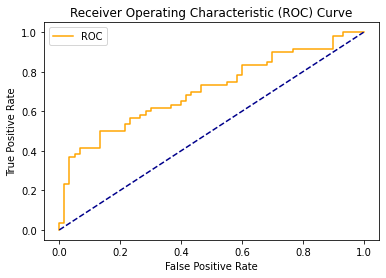

Threshold value is: 0.5382078037021576


0.6306306306306307

In [33]:
# import roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

predictions_prob = clf.predict_proba(data)
pred_classes = clf.predict(data)
false_positive_rate, recall, thresholds = roc_curve(classes, predictions_prob[:,1])
roc_auc = auc(false_positive_rate, recall)
plot_roc_curve(false_positive_rate, recall)

# optimal_idx = np.argmax(recall - false_positive_rate)
optimal_idx = np.argmax(recall - false_positive_rate)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
# plot_roc_curve(false_positive_rate, recall)

from sklearn.metrics import f1_score
f1_score(classes, pred_classes)

In [11]:
# nr_chans = 18

# Epochen beider klassen extrahieren aus matlab 
# kontinuierliche daten laden um das event herum 5s vor dem event und .5s nach dem event
long_pre_move = scipy.io.loadmat(path+os.sep+pID+os.sep+'long_pre_move_Baseline.mat')
long_idle = scipy.io.loadmat(path+os.sep+pID+os.sep+'long_idle_Baseline.mat')
all_idle = long_idle['long_idle']
all_pre_move = long_pre_move['long_pre_move']

# select channels
chans = np.squeeze(np.array(all_chans[0:nr_chans]) - 1).tolist()
print(chan_names.Var1[chans])

idle = all_idle[chans, :, :]
pre_move = all_pre_move[chans, :, :]

# moving window applying classifier
# TODO check where the windows in time actually are
target_class = 1
window_size = 250
probs_idle = np.zeros((idle.shape[2], idle.shape[1] - window_size + 1))
probs_pre_move = np.zeros((pre_move.shape[2], pre_move.shape[1] - window_size + 1))

for i in range(idle.shape[2]):
    for j in range(idle.shape[1] - window_size + 1):
        idle_windowed = idle[:,j:j+window_size,i]
        feats = slope(idle_windowed, 'linear').flatten().reshape(1,-1)
        probs_idle[i,j] = clf.predict_proba(feats)[0][int(target_class)]
        # probs_idle[i,j] = clf.transform(feats)[0][0]

for i in range(pre_move.shape[2]):
    for j in range(pre_move.shape[1] - window_size + 1):
        pre_move_windowed = pre_move[:,j:j+window_size,i]
        feats = slope(pre_move_windowed, 'linear').flatten().reshape(1,-1)
        probs_pre_move[i,j] = clf.predict_proba(feats)[0][int(target_class)]
        # probs_pre_move[i,j] = clf.transform(feats)[0][0]

23     Cz
24     C4
7      C3
49    PO8
17     O2
52    CPz
50     P6
4     FT9
18     P4
15     O1
Name: Var1, dtype: object


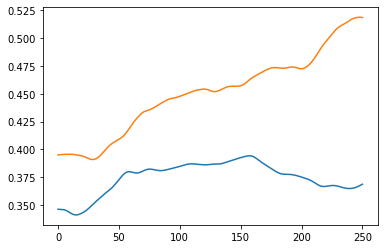

In [12]:
# plot mean curve of probs_idle using seaborn
import seaborn as sns

# with sns.plotting_context('paper', font_scale = 1.8):
#     fig, ax = plt.subplots(1, 1, figsize=(9,5))
#     fig.patch.set_alpha(1)
#     sns.despine() #bottom=True, left=True 3
    
#     data_to_plot = data.groupby(['stimulation','pID']).mean().reset_index()
#     data_to_plot.drop(columns=['pID', 'task_duration'], inplace=True)
    
#     data_long = pd.melt(data_to_plot, id_vars= 'stimulation', var_name='time (ms)', value_name='erp')
#     data_long['time (ms)'] = (((1/250) * (data_long["time (ms)"].str.replace("erp","").astype(int)))*1000) + -50

#     ax = sns.lineplot(data = data_long, x = 'time (ms)', y = 'erp', hue = 'stimulation')
#     ax.set_xlabel('Time (Hz)')
#     ax.set_ylabel('µV')
    
#     for i in marker:
#         ax.plot(i,-1.2, marker="s", markersize=4, color="purple")
    
#     plt.show()

import matplotlib.pyplot as plt

plt.plot(np.mean(probs_idle, axis=0))
plt.plot(np.mean(probs_pre_move, axis=0))

In [13]:
np.percentile(np.mean(probs_idle[:,200:250], axis=1), 50)

0.347294746506698

In [14]:
np.percentile(np.mean(probs_pre_move[:,200:250], axis=1), 50)

0.5014547142102255

(array([ 4.,  8.,  6.,  9., 10., 11.,  6.,  9.,  7.,  5.]),
 array([0.09787878, 0.17812775, 0.25837672, 0.33862569, 0.41887465,
        0.49912362, 0.57937259, 0.65962156, 0.73987053, 0.8201195 ,
        0.90036847]),
 <BarContainer object of 10 artists>)

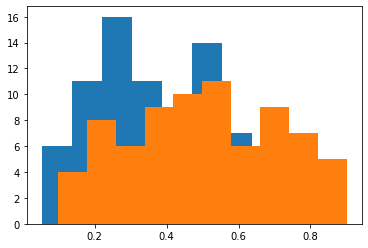

In [15]:
plt.hist(np.mean(probs_idle[:,200:250], axis=1))
plt.hist(np.mean(probs_pre_move[:,200:250], axis=1))

In [16]:
template = np.mean(probs_pre_move, axis=0)
corr_pre_move = np.corrcoef(template, probs_pre_move)[0][1:]
corr_idle = np.corrcoef(template, probs_idle)[0][1:]

# 50th percentile of correlation values
corr_pre_move_thresh = np.percentile(corr_pre_move, 50)
corr_idle_thresh = np.percentile(corr_idle, 80)

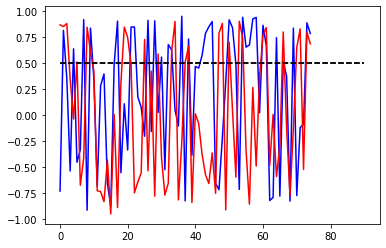

In [17]:
template = np.mean(probs_pre_move, axis=0)
corr_pre_move = np.corrcoef(template, probs_pre_move)[0][1:]
corr_idle = np.corrcoef(template, probs_idle)[0][1:]

# 50th percentile of correlation values
corr_pre_move_thresh = np.percentile(corr_pre_move, 50)
corr_idle_thresh = np.percentile(corr_idle, 80)

plt.plot(corr_pre_move, label='pre_move', color='blue')
# draw a line at .5
plt.plot([0, 90], [.5, .5], 'k--')

plt.plot(corr_idle, label='idle', color='red')
# draw a line at .5
plt.plot([0, 90], [.5, .5], 'k--')

In [18]:
# plot whole timeseries of windowed mean correlation coefficient with markers for events to determine a good threshold

# testen wie es mit den tatsächlichen daten aussieht auf die nicht trainiert wurde, restreamen?
long_pre_move = scipy.io.loadmat(path+os.sep+pID+os.sep+'long_pre_move_agency1.mat')
long_idle = scipy.io.loadmat(path+os.sep+pID+os.sep+'long_idle_agency1.mat')
all_idle = long_idle['long_idle']
all_pre_move = long_pre_move['long_pre_move']

In [19]:
# Epochen beider klassen extrahieren aus matlab 
# kontinuierliche daten laden um das event herum 5s vor dem event und .5s nach dem event

# select channels
chans = np.squeeze(np.array(all_chans[0:nr_chans]) - 1).tolist()
print(chan_names.Var1[chans])

idle = all_idle[chans, :, :]
pre_move = all_pre_move[chans, :, :]

# moving window applying classifier
# TODO check where the windows in time actually are
target_class = 1
window_size = 250
probs_idle = np.zeros((idle.shape[2], idle.shape[1] - window_size + 1))
probs_pre_move = np.zeros((pre_move.shape[2], pre_move.shape[1] - window_size + 1))

for i in range(idle.shape[2]):
    for j in range(idle.shape[1] - window_size + 1):
        idle_windowed = idle[:,j:j+window_size,i]
        feats = slope(idle_windowed, 'linear').flatten().reshape(1,-1)
        probs_idle[i,j] = clf.predict_proba(feats)[0][int(target_class)]
        # probs_idle[i,j] = clf.transform(feats)[0][0]

for i in range(pre_move.shape[2]):
    for j in range(pre_move.shape[1] - window_size + 1):
        pre_move_windowed = pre_move[:,j:j+window_size,i]
        feats = slope(pre_move_windowed, 'linear').flatten().reshape(1,-1)
        probs_pre_move[i,j] = clf.predict_proba(feats)[0][int(target_class)]
        # probs_pre_move[i,j] = clf.transform(feats)[0][0]

23     Cz
24     C4
7      C3
49    PO8
17     O2
52    CPz
50     P6
4     FT9
18     P4
15     O1
Name: Var1, dtype: object


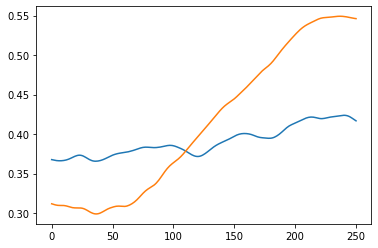

In [20]:
plt.plot(np.mean(probs_idle, axis=0))
plt.plot(np.mean(probs_pre_move, axis=0))

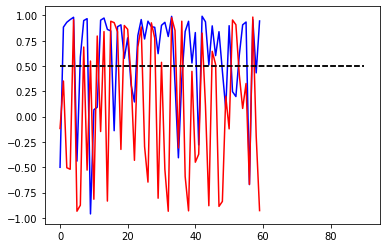

In [21]:
template = np.mean(probs_pre_move, axis=0)
corr_pre_move = np.corrcoef(template, probs_pre_move)[0][1:]
corr_idle = np.corrcoef(template, probs_idle)[0][1:]

# 50th percentile of correlation values
corr_pre_move_thresh = np.percentile(corr_pre_move, 50)
corr_idle_thresh = np.percentile(corr_idle, 80)

plt.plot(corr_pre_move, label='pre_move', color='blue')
# draw a line at .5
plt.plot([0, 90], [.5, .5], 'k--')

plt.plot(corr_idle, label='idle', color='red')
# draw a line at .5
plt.plot([0, 90], [.5, .5], 'k--')